In [1]:
import os
import fastai
from fastai.vision.all import *
from fastcore.xtras import Path
from fastai.data import *
import torch
import numpy as np
from PIL import Image
import json

In [2]:
print(torch.cuda.is_available())

True


In [3]:
# Enables IPywidgets
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

### **Get all files**

In [4]:
label = 'mast'
local_path = 'O:\Dataingeniør Bachelor\\6. Semester\DAT255\course-project'
data_path = local_path + '/data/self-collected'
mask_path = data_path + f'/labels/{label}'
image_path = data_path + f'/images'

valid_path = data_path + f'/val/valid.txt'
codes_path = data_path + f'/val/codes.json'

def _get_file_names(path):
    '''
    @param path
    @return list of filenames
    '''
    return [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]


get_msk = lambda o: Path(f'{mask_path}\\{o}')
get_img = lambda o: Path(f'{image_path}\\{o}')

In [5]:
imgs_fns = _get_file_names(image_path)
valid_fns = Path(valid_path).read_text().split('\n')

codes = json.load(open(codes_path)).get(label)

In [6]:
img_fn = imgs_fns[0]
mask = PILMask.create(get_msk(img_fn))
img = PILImage.create(image_path + '/' + img_fn)
# mask.show()
# img.show()
# print(tensor(mask)[0])
# print(mask)

In [7]:
""" mast = DataBlock(blocks=(ImageBlock, MaskBlock(codes)), 
    get_items=_get_file_names, 
    splitter= RandomSplitter(valid_pct=0.2),
    get_y = get_msk,
    get_x = get_img,
    batch_tfms=[Normalize.from_stats(*imagenet_stats, cuda=True)],
    item_tfms=Resize((300, 200))) """

mast= DataBlock(blocks=(ImageBlock, MaskBlock(codes)), 
    get_items=_get_file_names, 
    splitter= RandomSplitter(valid_pct=0.2),
    get_y = get_msk,
    get_x = get_img,
    item_tfms=Resize(300, 200),
    batch_tfms=[*aug_transforms(size=224, min_scale=0.75), Normalize.from_stats(*imagenet_stats, cuda=True)],)

In [8]:
dls = mast.dataloaders(source=image_path, device=torch.device('cuda'), bs=6)

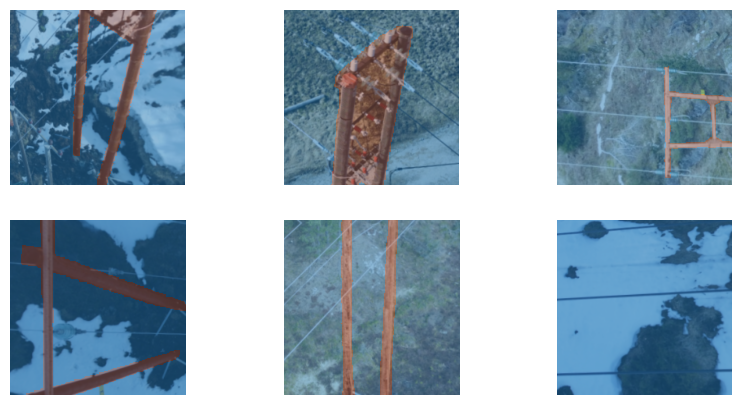

In [14]:
dls.show_batch(figsize=(10, 5))

In [9]:
learn = unet_learner(dls, resnet34, pretrained=True)

o:\Dataingeniør Bachelor\6. Semester\DAT255\course-project\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
o:\Dataingeniør Bachelor\6. Semester\DAT255\course-project\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
learn.fine_tune(100)

epoch,train_loss,valid_loss,time
0,0.274730,0.231273,00:03
1,0.243528,0.189811,00:03
2,0.226967,0.164148,00:04
3,0.205851,0.153464,00:03
4,0.186998,0.148711,00:03
5,0.175112,0.124738,00:03
6,0.165605,0.141044,00:04
7,0.157423,0.115976,00:04
8,0.146790,0.113750,00:04
9,0.136954,0.169366,00:04


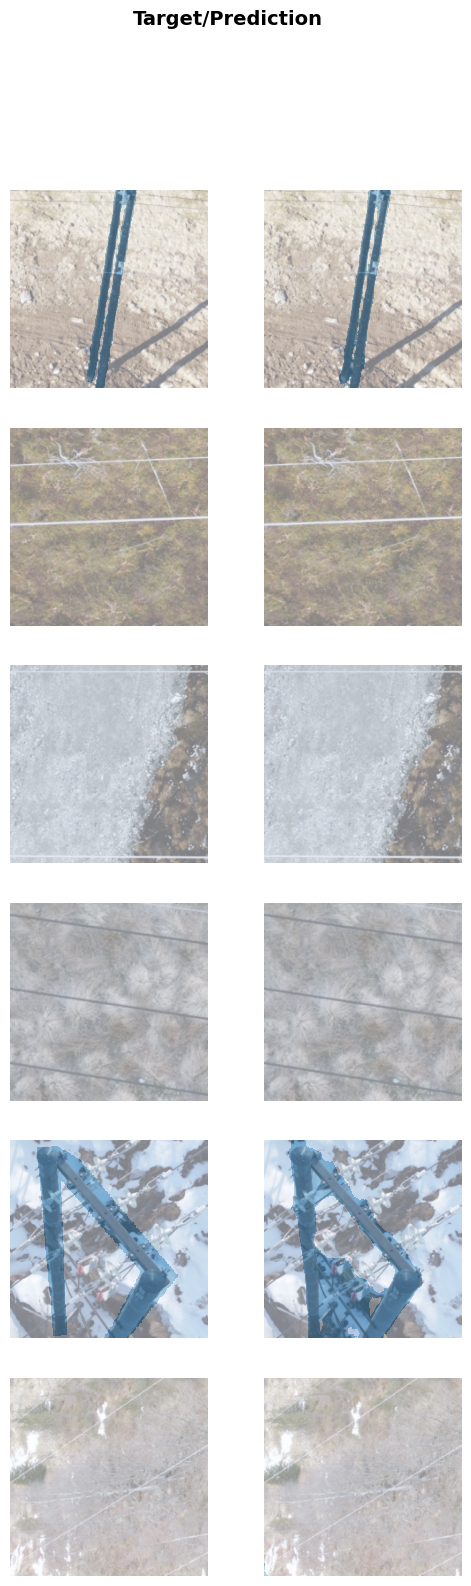

In [22]:
learn.show_results(cmap='Blues')

In [14]:
preds = learn.get_preds()

In [15]:
preds[0][0].shape

torch.Size([2, 224, 224])

In [16]:
p = preds[0][0]

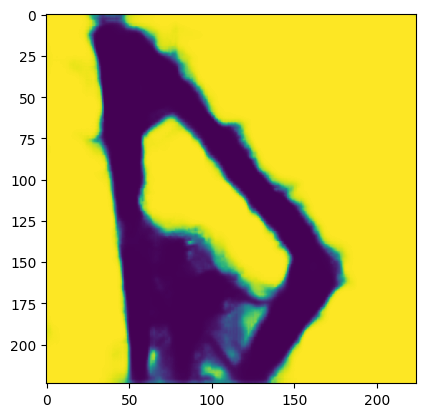

In [17]:
plt.imshow(p[0])

In [18]:
learn.save("unet-resnet-18-mast-100-epochs", with_opt=True)

Path('models/unet-resnet-18-mast-100-epochs.pth')